In [1]:
import napari
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology
from scipy import signal
from skimage.measure import label, regionprops_table
import pandas as pd

In [2]:
seed = 42
np.random.seed(seed)

## Generate signals

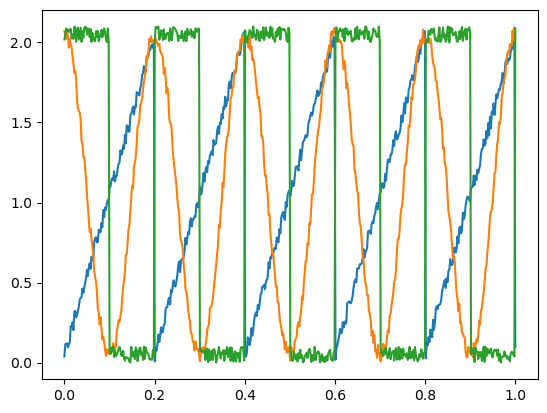

In [3]:
freq=5
time = np.linspace(0, 1, 500)
sawtooth = signal.sawtooth(2*np.pi*freq*time) + 1 + np.random.random(size=len(time))/10
cosine = np.cos(2*np.pi*freq*time) + 1 + np.random.random(size=len(time))/10
pulses = signal.square(2*np.pi*freq*time) + 1 + np.random.random(size=len(time))/10

signals = [cosine, pulses, sawtooth]

plt.plot(time, sawtooth)
plt.plot(time, cosine)
plt.plot(time, pulses)

## Generate objects

In [4]:
disk = morphology.disk(4)

In [5]:
square = morphology.square(9)
square[square==1] = 2

In [6]:
diamond = morphology.diamond(4)
diamond[diamond==1] = 3

In [7]:
objects_list = [disk, square, diamond]

In [8]:
image = np.zeros((100, 100))
object_order = []
for i in range(10):
    for j in range(3):
        n = np.random.randint(low=0, high=3, size=1)[0]
        obj = objects_list[n]
        image[i*10: i*10+9, 20 + j*20 :20 + j*20 + 9] = obj
        object_order.append(n)
        
    

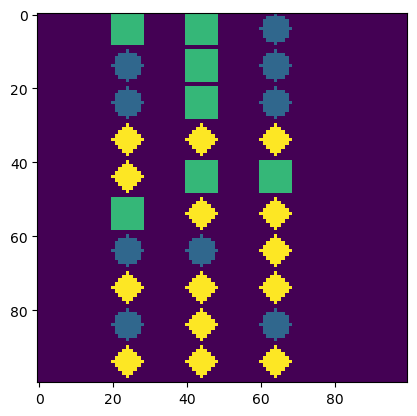

In [9]:
plt.imshow(image)

## Add signal to image label

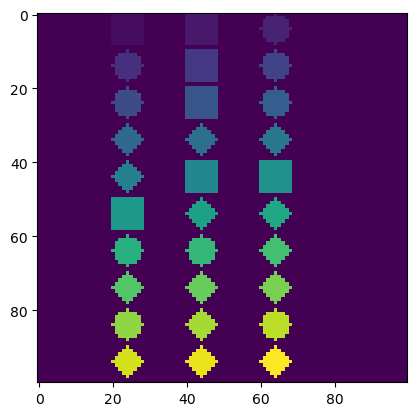

In [10]:

label_image = label(image)
plt.imshow(label_image)

In [11]:
height, width = image.shape
time_points = time.shape[0]
time_lapse = np.zeros((time_points, height, width))
for i in range(label_image.max()):
    # print(object_order[i])
# for label in [1, 2, 3]:
    mask = (label_image == i+1) # create boolean mask for current label
    signal = signals[object_order[i]]  # get corresponding signal for current label
    time_lapse[:,mask] = signal.reshape((time_points, -1)) # assign signal to region corresponding to current label


## Get intensities

In [12]:
df = pd.DataFrame([])
for i in range(time_points):
    features = regionprops_table(label_image, intensity_image=time_lapse[i], properties=('label', 'mean_intensity'))
    features['frame'] = i
    # data = features.values()
    df = pd.concat([df, pd.DataFrame(features)])

In [13]:
df

,label,mean_intensity,frame
0,1,2.018513,0
1,2,2.018513,0
2,3,2.069816,0
3,4,2.069816,0
4,5,2.018513,0
...,...,...,...
25,26,0.098621,499
26,27,2.044601,499
27,28,0.098621,499
28,29,0.098621,499


In [14]:
array = np.zeros((label_image.max(), time_points))
for i in range(label_image.max()):
    intensities = df[df['label']==1]['mean_intensity'].values
    array[i, :] = intensities


In [15]:
array = array.T

## Add to naapri

In [16]:
viewer = napari.Viewer()
viewer.add_image(time_lapse)
averages = np.mean(time_lapse, axis=(1,2))
viewer.add_labels(label_image, metadata={'time-series-plugin': {'time': time, 'average': array}})
# viewer.add_labels(label_image, features=df)

<Labels layer 'label_image [1]' at 0x217a2ab54f0>

In [17]:
from napari_matplotlib.line import MetadataLine2DWidget

In [18]:
plotter_widget = MetadataLine2DWidget(viewer)
viewer.window.add_dock_widget(plotter_widget)